In [1]:
from google.colab import drive
import zipfile
import os

drive.mount('/content/drive')

zip_path = '/content/drive/My Drive/hand_over_face.zip'
extract_path = '/content/hand_over_face'
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" Dataset extracted.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Dataset extracted.


In [2]:
import glob
import os

rgb_root = '/content/hand_over_face/RGB'
mask_root = '/content/hand_over_face/Mask'

rgb_files = sorted(glob.glob(os.path.join(rgb_root, '**', '*.jpg'), recursive=True))
mask_files = sorted(glob.glob(os.path.join(mask_root, '**', '*.png'), recursive=True))

print(f" Found {len(rgb_files)} RGB images")
print(f" Found {len(mask_files)} mask images")


 Found 4385 RGB images
 Found 4385 mask images


In [3]:
rgb_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in rgb_files}
mask_dict = {os.path.splitext(os.path.basename(p))[0]: p for p in mask_files}

common_keys = set(rgb_dict.keys()) & set(mask_dict.keys())
paired_files = [(rgb_dict[k], mask_dict[k]) for k in common_keys]
paired_files = sorted(paired_files, key=lambda x: os.path.basename(x[0]))

print(f" Found {len(paired_files)} matched image-mask pairs.")


 Found 4385 matched image-mask pairs.


 All 4385 images processed.

 Debug view (5 random images with face + overlap boxes):


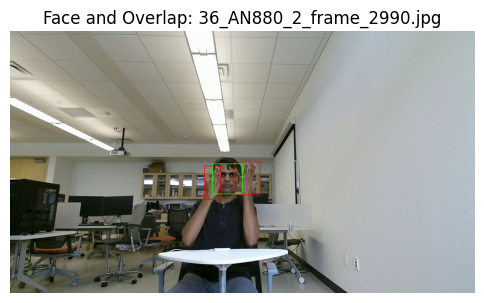

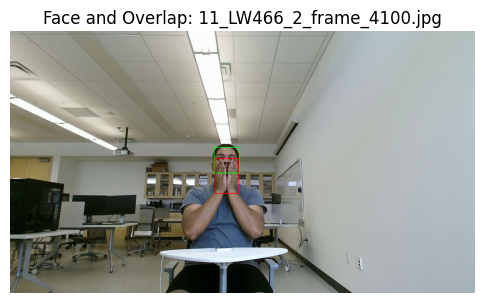

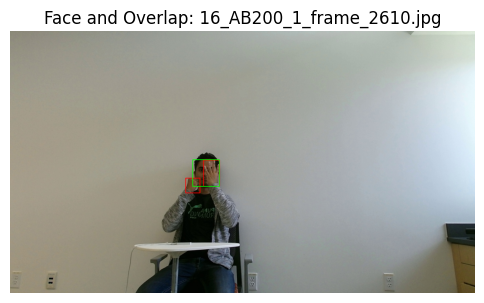


 Showing 10 cropped hand-over-face images:
Cropped Hand 1: 37_MN317_1_frame_1910_obj1.jpg


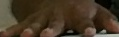

Cropped Hand 2: 17_QA498_1_frame_3540_obj1.jpg


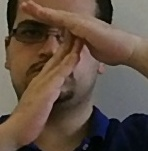

Cropped Hand 3: 02_AH058_1_frame_2030_obj2.jpg


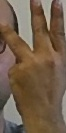

Cropped Hand 4: 17_QA498_2_frame_1910_hand2.jpg


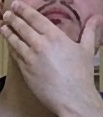

Cropped Hand 5: 17_QA498_1_frame_1090_hand2.jpg


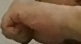

Cropped Hand 6: 11_LW466_1_frame_2970_hand1.jpg


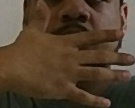

Cropped Hand 7: 06_MD551_1_frame_670_hand30.jpg


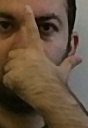

Cropped Hand 8: 37_MN317_1_frame_3350_hand2.jpg


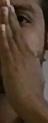

Cropped Hand 9: 40_VN416_1_frame_2680_obj2.jpg


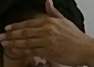

Cropped Hand 10: 04_AQ932_1_frame_1280_hand9.jpg


In [5]:
import cv2
import numpy as np
import os
import glob
import random
from matplotlib import pyplot as plt
from IPython.display import Image, display

output_dir = '/content/cropped_outputs'
os.makedirs(output_dir, exist_ok=True)

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

def crop_hands_overlapping_face(rgb_path, mask_path, show_debug=False, overlap_thresh=0.1):
    image = cv2.imread(rgb_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=3)
    if len(faces) == 0:
        return False

    fx, fy, fw, fh = faces[0]
    face_mask = np.zeros_like(mask)
    face_mask[fy:fy+fh, fx:fx+fw] = 255

    _, binary_hand_mask = cv2.threshold(mask, 10, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_hand_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cropped_any = False
    debug_img = image.copy()

    for i, cnt in enumerate(contours):
        x, y, w, h = cv2.boundingRect(cnt)
        hand_mask = np.zeros_like(mask)
        cv2.drawContours(hand_mask, [cnt], -1, 255, -1)

        overlap = cv2.bitwise_and(face_mask, hand_mask)
        overlap_area = np.count_nonzero(overlap)
        hand_area = np.count_nonzero(hand_mask)

        if hand_area == 0:
            continue

        if overlap_area / hand_area >= overlap_thresh:
            cropped = image[y:y+h, x:x+w]
            base_name = os.path.splitext(os.path.basename(rgb_path))[0]
            out_path = os.path.join(output_dir, f"{base_name}_hand{i+1}.jpg")
            cv2.imwrite(out_path, cropped)
            cropped_any = True

            if show_debug:
                cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0, 0, 255), 2)

    if show_debug:
        cv2.rectangle(debug_img, (fx, fy), (fx+fw, fy+fh), (0, 255, 0), 2)
        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Face and Overlap: {os.path.basename(rgb_path)}")
        plt.axis('off')
        plt.show()

    return cropped_any

for rgb_path, mask_path in paired_files:
    crop_hands_overlapping_face(rgb_path, mask_path)

print(f" All {len(paired_files)} images processed.\n")
print(" Debug view (5 random images with face + overlap boxes):")
sample_debug = random.sample(paired_files, min(5, len(paired_files)))
for rgb_path, mask_path in sample_debug:
    crop_hands_overlapping_face(rgb_path, mask_path, show_debug=True)
cropped_images = sorted(glob.glob(os.path.join(output_dir, '*.jpg')))
num_show = min(10, len(cropped_images))

if num_show > 0:
    print(f"\n Showing {num_show} cropped hand-over-face images:")
    sample_cropped = random.sample(cropped_images, num_show)
    for i, path in enumerate(sample_cropped, 1):
        print(f"Cropped Hand {i}: {os.path.basename(path)}")
        display(Image(filename=path))
else:
    print(" No valid cropped hand images found.")
